**Image segmentation without labelled data**

One model classifies the image while the other tries to mask it.
The mask model is incentivized to mask out the image while maintaining accuracy with the classification model. The idea is that the model will learn to mask out irrelevant background while preserving the object, creating segmentation that can be used to localize images on other datasets

In [35]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0




model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4796 - accuracy: 0.8615
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1500 - accuracy: 0.9560
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1074 - accuracy: 0.9686
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0831 - accuracy: 0.9737
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0742 - accuracy: 0.9766


In [36]:
import numpy as np

mask_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(28*28, activation='sigmoid')
])



In [37]:
from tensorflow.keras import backend as K

sgd = tf.keras.losses.CategoricalCrossentropy()


def loss_fn(y_pred, y_true, mask):
  return sgd(y_pred, y_true) + K.cast(K.sum(mask) / 784, dtype='float64') / 20


optimizer = tf.keras.optimizers.Adam(1e-4)


def train_step(images, labels):
  with tf.GradientTape() as tape:
    mask = mask_model(images, training=True)
    mask = tf.reshape(mask, [-1, 28, 28])
    masked_images = mask * images

    prediction = model(masked_images)

    loss = loss_fn(prediction, labels, mask)

    
  gradients = tape.gradient(loss, mask_model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, mask_model.trainable_variables))

  return loss


def train(images, labels, epochs):

  for epoch in range(epochs):
    loss = 0
    for image, label in zip(images, labels):
      loss += train_step(image, label)
    print('Epoch {}: {}'.format(epoch, loss))

BATCH_SIZE = 32

y = np.zeros((y_train.size, int(y_train.max()+1)))
y_train = y_train.astype('int32')
y[np.arange(y_train.size), y_train] = 1
y_train = y

x_train = x_train.reshape(-1, BATCH_SIZE, 28, 28)
y_train = y_train.reshape(-1, BATCH_SIZE, 10)


train(x_train, y_train, epochs=20)


Epoch 0: 2252.765571593495
Epoch 1: 1849.5965847359996
Epoch 2: 1680.82426250279
Epoch 3: 1585.522637635004
Epoch 4: 1515.6564897997305
Epoch 5: 1452.5009518429608
Epoch 6: 1398.1751341049574
Epoch 7: 1350.9767822328956
Epoch 8: 1306.5876168430793
Epoch 9: 1267.0350126722863
Epoch 10: 1229.2308359286767
Epoch 11: 1194.4381399720905
Epoch 12: 1162.9027696027408
Epoch 13: 1127.270232841327
Epoch 14: 1103.7157352823758
Epoch 15: 1067.6062840227044
Epoch 16: 1043.7844614969574
Epoch 17: 1021.7270563264393
Epoch 18: 994.8066490196167
Epoch 19: 972.4758495084485


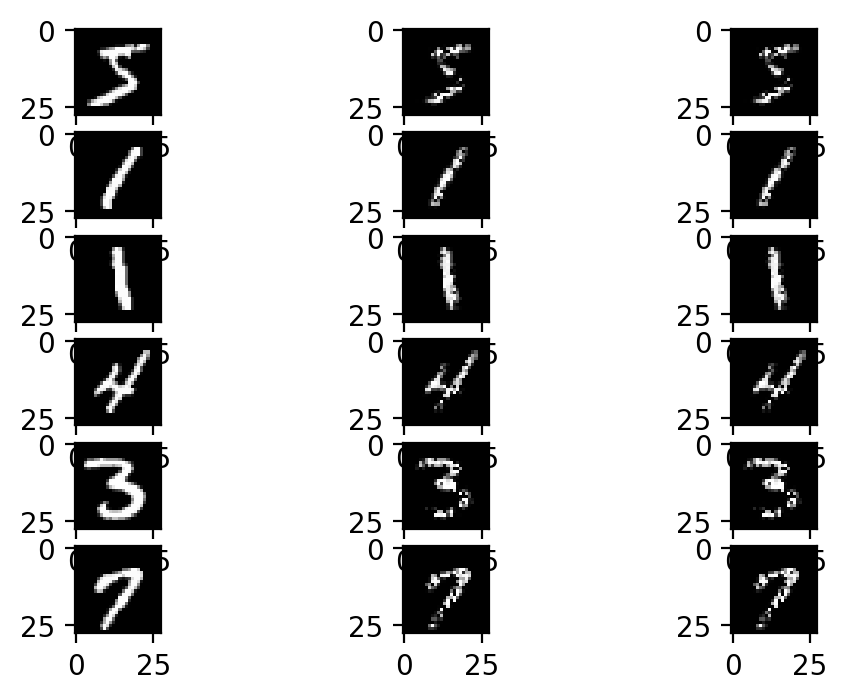

In [40]:
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

test = x_train[0]
mask = mask_model(test)
mask = tf.reshape(mask, [-1, 28, 28])
masked = mask * test


fig = plt.figure(dpi=200)

for i in range(0, 18, 3):
  plt.subplot(6, 3, i+1)
  plt.imshow(test[i], cmap='gray')

  plt.subplot(6, 3, i+2)
  plt.imshow(masked[i], cmap='gray')

  plt.subplot(6, 3, i+3)
  plt.imshow(masked[i], cmap='gray')


plt.show()
